# Grid based SEPP method(s)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

# With real data

In [2]:
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime, os
import open_cp.predictors
import open_cp.kernels

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

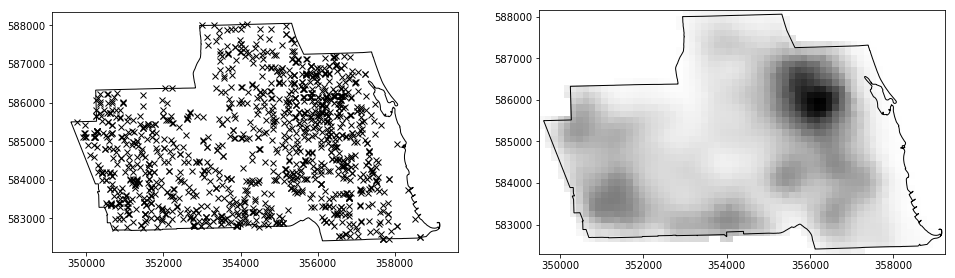

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Save out data

In [7]:
#import csv, gzip
#
#with gzip.open("Chicago_North_2016.csv.gz", "wt", encoding="utf8", newline="") as f:
#    writer = csv.writer(f)
#    writer.writerow(["x", "y", "iso_time"])
#    for x, y, t in zip(points.xcoords, points.ycoords, points.timestamps):
#        writer.writerow([x,y,t])

## Continue with analysis

In [8]:
def add_random_noise(points):
    ts = points.timestamps + np.random.random(size=points.timestamps.shape) * 60 * 1000 * np.timedelta64(1,"ms")
    ts = np.sort(ts)
    return points.from_coords(ts, points.xcoords, points.ycoords)

In [9]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)

In [10]:
model

ExpDecayModel(T=365.9579817361111, theta=0.021257387235961506, omega=18.299813747460142, mu size=(39, 65)

In [11]:
pred = trainer.prediction_from_background(model)

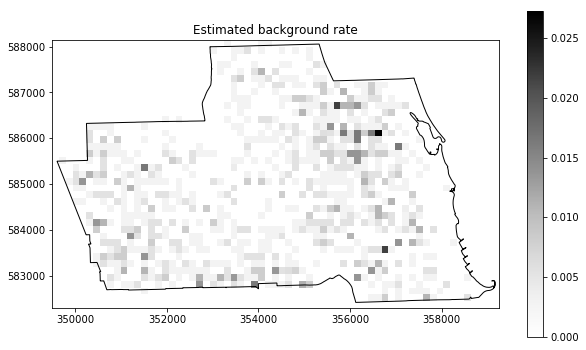

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")
None

In [13]:
np.max(model.mu), np.min(model.mu)

(0.027325541453036672, 0.0)

Unfortunately, the predicted parameters are not very "realistic".  The triggering kernel is
$$ g(t) = \theta \omega e^{-\omega t} $$
with time measured in "days".  We estimate $1 / \omega \approx 79$ _minutes_, and $\theta$ comparable to the background rate.   This means that events need to be very near in time before the triggering kernel adds much.

In [14]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)

In [15]:
model

ExpDecayModel(T=365.95807804398146, theta=0.021277172216035214, omega=18.181143544227375, mu size=(39, 65)

In [16]:
24 * 60 / model.omega

79.202938830391062

## With old code

Check that we get the same result with the main `open_cp` code.  (For a while, this had poorly chosen initial conditions, which lead to convergence problems.  I've now fixed this.)

In [17]:
import open_cp.seppexp

In [18]:
trainer = open_cp.seppexp.SEPPTrainer(grid=grid)
trainer.data = add_random_noise(points)
predictor = trainer.train(iterations=50)

In [19]:
predictor.theta, predictor.omega * 60 * 24

(0.021263409042810596, 18.237316494388146)

In [20]:
predictor = trainer.train(iterations=50, use_corrected=True)

In [21]:
predictor.theta, predictor.omega * 60 * 24

(0.021284882247965115, 18.226326574862728)

## Allowing repeats

We'll also bin the data to the nearest day (moving to noon each day).

This gives $\omega^{-1} = 2.6$ days.  But notice that $\theta$ is now tiny!  Indeed, using either edge correction or not, if we run the algorithm for longer, then $\theta$ tends to 0.

In [22]:
pts = points.bin_timestamps(np.datetime64("2017-01-01T12:00"), np.timedelta64(1, "D"))

In [23]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = pts
model = trainer.train(datetime.datetime(2017,1,1), iterations=200, use_fast=False)
model

ExpDecayModel(T=366.5, theta=1.3611441379012238e-35, omega=0.3809182170714781, mu size=(39, 65)

In [24]:
1 / model.omega

2.6252354316053967

Binning to 12 hours seems to work better, but $\omega^{-1}$ is still a bit small.

Changing the offset to 6am gets back the old $\theta \approx 0$ behaviour.  After worrying a bit this was the algorithm, but I think it shows some unexpected dependence on the distribution of timestamps in the input data.
- If we bin to the nearest 12 hours, with an offset of midnight, it "works"
- Changing the offset to 6am, and we get a much smaller $\theta$
- If we subtract 6 hours from the original timestamps, and then bin with the offset of 6am, it goes back to "working" (as it should!)

In [25]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T12:00"), np.timedelta64(12, "h"))
model = trainer.train(datetime.datetime(2017,1,2, 0,0), iterations=200, use_fast=False)
model

ExpDecayModel(T=367.0, theta=0.003243024078966483, omega=0.9489707893621647, mu size=(39, 65)

In [26]:
trainer.data.time_range

(numpy.datetime64('2016-01-01T00:00:00.000'),
 numpy.datetime64('2016-12-31T00:00:00.000'))

In [27]:
cells, _ = trainer.make_points(datetime.datetime(2017,1,2, 0,0))
min([np.min(x) for x in cells.flat if len(x)>0]), max([np.max(x) for x in cells.flat if len(x)>0])

(-367.0, -2.0)

In [28]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T06:00"), np.timedelta64(12, "h"))
model = trainer.train(datetime.datetime(2017,1,1), iterations=200, use_fast=False)
model

ExpDecayModel(T=366.25, theta=8.869258820562624e-05, omega=0.8858273241416412, mu size=(39, 65)

In [29]:
trainer.data.time_range

(numpy.datetime64('2015-12-31T18:00:00.000'),
 numpy.datetime64('2016-12-31T06:00:00.000'))

In [30]:
cells, _ = trainer.make_points(datetime.datetime(2017,1,1))
min([np.min(x) for x in cells.flat if len(x)>0]), max([np.max(x) for x in cells.flat if len(x)>0])

(-366.25, -0.75)

In [31]:
ts = points.timestamps - np.timedelta64(6, "h")
pts = open_cp.data.TimedPoints(ts, points.coords)

trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = pts.bin_timestamps(np.datetime64("2017-01-01T06:00"), np.timedelta64(12, "h"))
model = trainer.train(datetime.datetime(2017,1,1), iterations=200, use_fast=False)
model

ExpDecayModel(T=366.25, theta=0.003210423270165148, omega=0.9478216159428341, mu size=(39, 65)

In [32]:
trainer.data.time_range

(numpy.datetime64('2015-12-31T18:00:00.000'),
 numpy.datetime64('2016-12-30T18:00:00.000'))

In [33]:
cells, _ = trainer.make_points(datetime.datetime(2017,1,1))
min([np.min(x) for x in cells.flat if len(x)>0]), max([np.max(x) for x in cells.flat if len(x)>0])

(-366.25, -1.25)

## More systematically explore binning offset

In [34]:
for hour in range(24):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
    trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T00:00")
                        + np.timedelta64(hour, "h"), np.timedelta64(1, "D"))
    model = trainer.train(datetime.datetime(2017,1,2, 0,0), iterations=50, use_fast=False)
    print(hour, model)

0 ExpDecayModel(T=367.0, theta=8.609636041131893e-06, omega=0.5597270806861646, mu size=(39, 65)
1 ExpDecayModel(T=366.9583333333333, theta=5.073486678003989e-06, omega=0.5323486971136907, mu size=(39, 65)
2 ExpDecayModel(T=367.9166666666667, theta=9.672108785726463e-05, omega=0.566541180183005, mu size=(39, 65)
3 ExpDecayModel(T=367.875, theta=3.582598542857831e-06, omega=0.5217137254055617, mu size=(39, 65)
4 ExpDecayModel(T=367.8333333333333, theta=2.926445912119268e-07, omega=0.48666768274926187, mu size=(39, 65)
5 ExpDecayModel(T=367.7916666666667, theta=1.982175986175827e-08, omega=0.4546376221569779, mu size=(39, 65)
6 ExpDecayModel(T=367.75, theta=9.256514416055003e-10, omega=0.41581150502449327, mu size=(39, 65)
7 ExpDecayModel(T=367.7083333333333, theta=4.373403119835958e-07, omega=0.495417305240195, mu size=(39, 65)
8 ExpDecayModel(T=367.6666666666667, theta=4.3467337340110607e-07, omega=0.49563883865358577, mu size=(39, 65)
9 ExpDecayModel(T=367.625, theta=1.702183714831601

In [35]:
by_hour = {}
for hour in range(24):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
    trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T00:00")
                        + np.timedelta64(hour, "h"), np.timedelta64(12, "h"))
    model = trainer.train(datetime.datetime(2017,1,2, 0,0), iterations=100, use_fast=False)
    print(hour, model)
    by_hour[hour] = model

0 ExpDecayModel(T=367.0, theta=0.0032432036684596206, omega=0.9489627946641321, mu size=(39, 65)
1 ExpDecayModel(T=366.9583333333333, theta=0.003205766509335343, omega=0.9585373719615704, mu size=(39, 65)
2 ExpDecayModel(T=367.4166666666667, theta=0.006093462076636629, omega=1.0104756428842214, mu size=(39, 65)
3 ExpDecayModel(T=367.375, theta=0.00029688680415250826, omega=0.8553520483602215, mu size=(39, 65)
4 ExpDecayModel(T=367.3333333333333, theta=0.00028041529544484313, omega=0.892311998434525, mu size=(39, 65)
5 ExpDecayModel(T=367.2916666666667, theta=0.00012084428153652972, omega=0.821974072670571, mu size=(39, 65)
6 ExpDecayModel(T=367.25, theta=0.00028976161260196084, omega=0.8840418547331337, mu size=(39, 65)
7 ExpDecayModel(T=367.2083333333333, theta=0.0075422697653490635, omega=1.1031731564706762, mu size=(39, 65)
8 ExpDecayModel(T=367.1666666666667, theta=0.007643619538733033, omega=1.0883157448770506, mu size=(39, 65)
9 ExpDecayModel(T=367.125, theta=0.005978747049047899

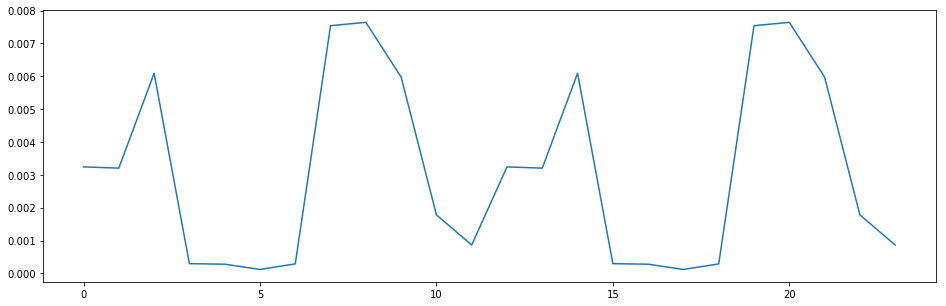

In [36]:
fig, ax = plt.subplots(figsize=(16, 5))
x = list(by_hour.keys())
x.sort()
y = [by_hour[t].theta for t in x]
ax.plot(x,y)

# Other regions of chicago

In [37]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [38]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2010-01-01")) & (all_points.timestamps < np.datetime64("2011-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

def train(grid, points):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
    trainer.data = add_random_noise(points)
    model = trainer.train(datetime.datetime(2011,1,1), iterations=50)
    return model

In [39]:
for side in sides:
    model = train(*load(side))
    print(side, model.theta, 24*60/model.omega, np.max(model.mu))

Far North 0.0211650361932 185.365131165 0.0274035532285
Northwest 0.00681160829279 10.948601996 0.0356334501919
North 0.0138781212265 73.969820739 0.0328804980047
West 0.017281921744 61.6255774365 0.0478002800615
Central 0.0385102166645 132.125242265 0.0219766503451
South 0.024982685835 118.676270123 0.06562568896
Southwest 0.0118579691939 158.695924855 0.0545937693535
Far Southwest 0.0142061685389 161.292798069 0.0438603395724
Far Southeast 0.0114304614565 139.017440292 0.0681950139539


In [40]:
def train(grid, points):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
    trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T12:00"), np.timedelta64(12, "h"))
    model = trainer.train(datetime.datetime(2011,1,1), iterations=50, use_fast=False)
    return model

In [41]:
for side in sides:
    model = train(*load(side))
    print(side, model.theta, 24*60/model.omega, np.max(model.mu))

Far North 0.00525530736526 1004.97200582 0.0273971007345
Northwest 1.26983857855e-10 1352.03548436 0.03561643835
North 2.88201392335e-06 3413.96789585 0.0328766957487
West 0.00345644536252 3028.43604536 0.0518434944878
Central 0.00513468800171 1997.44214737 0.0218404985553
South 0.0140745376937 2999.08708129 0.0651535001942
Southwest 7.73104320142e-06 5806.393035 0.0547939390002
Far Southwest 0.00050748324011 2046.47925254 0.043806307156
Far Southeast 0.000404846377804 2339.14179028 0.0712710486014
